    Jacob Knopping
    2/3/2020
    
## Capstone 2: Supervised Learning

### Prompt

You're ready to put into practice everything you've learned so far.

First: Go out and find a dataset of interest. It could be from one of our recommended resources, some other aggregation, or scraped yourself. Just make sure it has lots of variables in it, including an outcome of interest to you.

Second: Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

Third: Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.

Please execute the three tasks above in a Jupyter notebook that you will submit to the grading team below.

Next, in order to prepare for your presentation, create a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:

A specified research question your model addresses
How you chose your model specification and what alternatives you compared it to
The practical uses of your model for an audience of interest
Any weak points or shortcomings of your model
This presentation is not a drill. You'll be presenting this slide deck live to a group as the culmination of all your work so far on supervised learning. As a secondary matter, your slides and the Jupyter notebook should be worthy of inclusion as examples of your work product when applying to jobs.

Good luck!

### About the Data

The dataset chosen for this capstone project is the Titanic dataset from Kaggle. The outcome of interest is a classifier; we want to be able to predict whether or not a passenger on the Titanic survived by building a machine learning model, using the training data.

The variables in the dataset have the following meanings:
    
    PassengerId: unique id for each passenger
    Survived: 1= survived, 0 = did not survive
    Pclass: passenger class
    Name: the name of the passenger
    Sex: the sex of the passenger	
    Age: passenger age
    SibSp: number of siblings and spouses	
    ParCh: number of parents and children	
    Ticket: ticket number	
    Fare: price paid for ticket	
    Cabin: the cabin number of the passenger	
    Embarked: where the passenger boarded from

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

from sklearn.model_selection import cross_val_score

In [2]:
#Read csv files into dataframes
titanic_df = pd.read_csv('titanic_train.csv')
titanic_test = pd.read_csv('titanic_test.csv')
titanic_test_survival = pd.read_csv('titanic_gender_submission.csv')

### Initital EDA

In [3]:
#Create list for changes to datasets
datasets = [titanic_df, titanic_test]

#change column formatting to all lowercase
for dataset in datasets:
    dataset.columns = dataset.columns.str.lower()

In [4]:
titanic_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic_df.shape

(891, 12)

In [6]:
titanic_df['survived'].value_counts()

0    549
1    342
Name: survived, dtype: int64

This gives an initial understanding of the proportion of passengers that survived in the training data. Only 342 passengers survived, compared to 549 passengers that did not.

In [7]:
titanic_df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The .describe() method provides some quick insight into the variables. For example, the mean of 'survived' indicates that only about 38% of passengers survived, matching the numbers from above. In addition, the mean of the 'pclass' variable tells us that there were more third class passengers than first class, which can be confirmed below using the .value_counts() method.

In [8]:
titanic_df.pclass.value_counts()

3    491
1    216
2    184
Name: pclass, dtype: int64

### Data Cleaning

Let's explore the number of missing values.

In [9]:
print(len(titanic_df))
print(titanic_df.columns)
print(titanic_df.isnull().sum())

891
Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')
passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64


In [10]:
percent_miss = 100*titanic_df.isnull().sum()/len(titanic_df)
print(percent_miss)

passengerid     0.000000
survived        0.000000
pclass          0.000000
name            0.000000
sex             0.000000
age            19.865320
sibsp           0.000000
parch           0.000000
ticket          0.000000
fare            0.000000
cabin          77.104377
embarked        0.224467
dtype: float64


Cabin has a very high percentage of missing values and will be dropped as a result. Age only has 19.9% missing values, which can be dealt with using interpolation. Lastly, embarked only has two missing values, which can be filled in using the mode.

In [11]:
#Dealing with missing values

#Drop cabin, interpolate age, fill embarked with mode
for dataset in datasets:
    dataset.drop(columns = 'cabin', inplace=True)
    dataset.interpolate(inplace=True)
    dataset.fillna(dataset.mode().iloc[0], inplace=True)
    
print(titanic_df.isnull().sum())

passengerid    0
survived       0
pclass         0
name           0
sex            0
age            0
sibsp          0
parch          0
ticket         0
fare           0
embarked       0
dtype: int64


All missing values have been dealt with. With this particular dataset, the only outlier for consideration is fare. However, passengers paying high fares is valuable information is this dataset. Thus, outliers will not be adjusted for, in this instance.

### EDA/Feature Engingeering

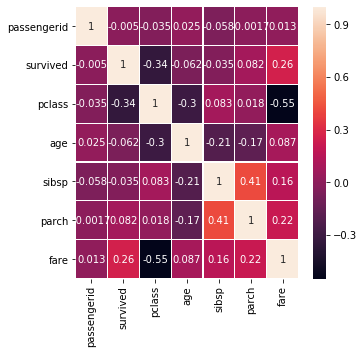

In [12]:
#Explore correlations

import seaborn as sns

plt.figure(figsize=(5,5))
corr = titanic_df.corr()
sns.heatmap(corr, annot=True, linewidths=.2)
plt.show()

Correlations do not appear to be particularly high for this dataset. Fare and passenger class have some negative correlation, and sibsp and parch have a somewhat positive correlation, both of which make sense. Combining the parch and sibsp features into a feature family_size might makes logical sense.

Now, let's create an overall visual for the different variables in the titanic training set to get a better feel more the relationships behind the data.

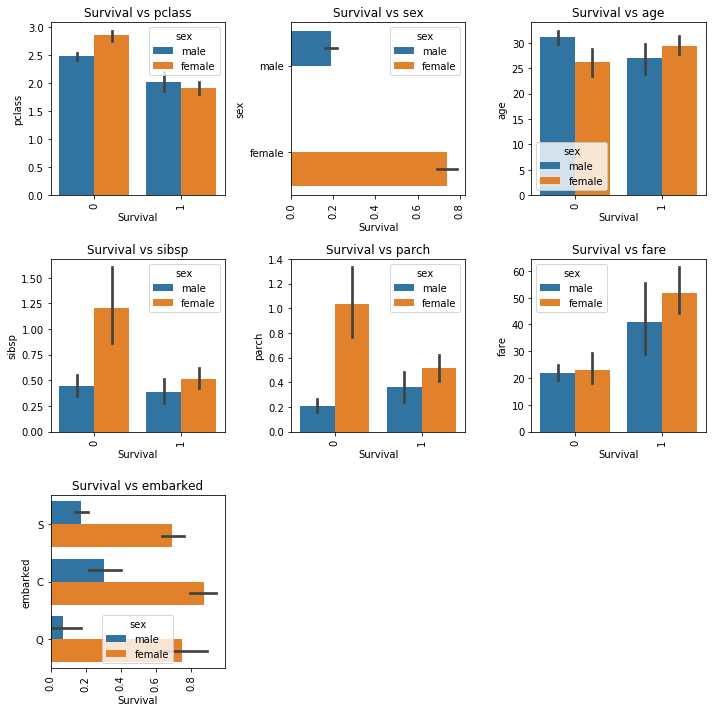

In [13]:
import seaborn as sns

titanic_fig = titanic_df.drop(['passengerid', 'name', 'ticket', 'survived'], axis=1)
fill_list = list(titanic_fig)

plt.figure(figsize=(10,10))

for index, column in enumerate(fill_list):
    #There are now 38 non-numeric columns
    plt.subplot(3,3,index+1)
    sns.barplot(x="survived", y=column, hue='sex', data=titanic_df)
    plt.title("Survival vs {}".format(column))
    plt.xlabel("Survival")
    plt.ylabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Some of the variables that initiallly stand out as having an effect on survival rate are sex, pclass, parch, sibsp, and embarked. All of these variables seem to have significance, and require further exploration.

__Sex:__

In [14]:
genders = {"male": 0, "female": 1}

for dataset in datasets:
    dataset['sex'] = dataset['sex'].map(genders)

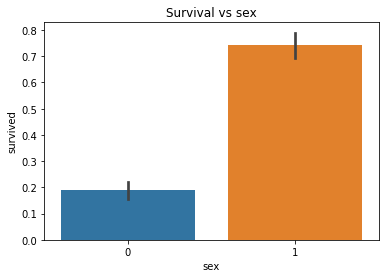

sex
0    0.188908
1    0.742038
Name: survived, dtype: float64

In [15]:
sns.barplot(x='sex', y='survived', data=titanic_df)
plt.title("Survival vs sex")
plt.show()

titanic_df.groupby('sex')['survived'].mean()

As suspected based on the earlier graphs, the surival rate for women (0.742) is much higher than for men (0.189).

__Pclass:__

In [16]:
titanic_df.pclass.value_counts()

3    491
1    216
2    184
Name: pclass, dtype: int64

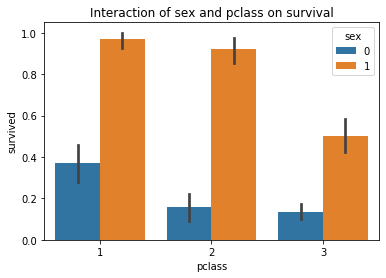

pclass,1,2,3
sex,,,
0,0.368852,0.157407,0.135447
1,0.968085,0.921053,0.500000


In [17]:
sns.barplot(x='pclass', y='survived', hue='sex', data=titanic_df)
plt.title("Interaction of sex and pclass on survival")
plt.show()

titanic_df.pivot_table('survived', index='sex', columns='pclass')

The interaction between sex and pclass has a significant impact on surival rate, as demonstrated in the table and barplot above. First class and second class women are much more likely to survive than third class women. In addition, first class men are more likely to survive than second and third class men.

Thus, it will be useful to create a feature based on this interaction between sex and pclass.

In [18]:
#Create interaction feature 
for dataset in datasets:
    dataset['sex_pclass']= dataset['sex']* dataset['pclass']

__Names (titles):__

In [19]:
#Get count of unique names
titanic_df.name.nunique()

891

Every passenger in the dataset has a unique name, making this feature useless on the surface. However, the titles for each name may hold valuable information once extracted.

In [20]:
#Extract titles from names
titanic_df.name.str.extract(' ([A-Za-z]+)\.', expand=False).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Countess      1
Jonkheer      1
Don           1
Ms            1
Mme           1
Capt          1
Lady          1
Sir           1
Name: name, dtype: int64

The counts for each title can be seen above. Master appears to have a relatively high frequency, in addition to the standard Mr, Miss, and Mrs titles. The rest of the titles will be considered to fall into a 'unique' category. 

In [21]:
#Create titles feature

#Map for titles
titles = {"Mr": 1, "Miss": 4, "Mrs": 5, "Master": 3, "unique": 2}

for dataset in datasets:
    #extraction
    dataset['title'] = dataset.name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')
    #group unique titles
    dataset['title'] = dataset['title'].replace(['Dr', 'Rev', 'Major', 'Col', 'Mlle', 'Sir', 'Ms', 'Capt', 'Jonkheer', 'Don', 'Lady', 'Countess', 'Mme'], 'unique')
    #Use map to convert titles to numbers
    dataset['title'] = dataset['title'].map(titles)
    #Fill any null values with zero
    dataset['title'] = dataset['title'].fillna(0)

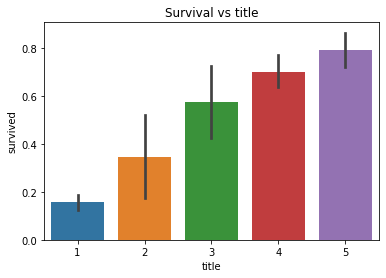

In [22]:
sns.barplot(x='title', y='survived', data=titanic_df)
plt.title("Survival vs title")
plt.show()

In [23]:
titanic_df[['title', 'sex']].corr()

,title,sex
title,1.000000,0.944195
sex,0.944195,1.000000


There is some correlation between title and sex, as suspected. However, this will only be considered problematic if both features do not have importance, which will be calculated after building and selecting a model.

__Embarked:__

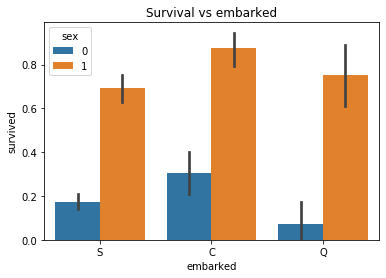

embarked
C    0.553571
Q    0.389610
S    0.339009
Name: survived, dtype: float64

In [24]:
sns.barplot(x='embarked', y='survived', hue='sex', data=titanic_df)
plt.title("Survival vs embarked")
plt.show()

titanic_df.groupby('embarked')['survived'].mean()

In [25]:
ports = {"S": 0, "C": 1, "Q": 2}

for dataset in datasets:
    dataset['embarked'] = dataset['embarked'].map(ports)

The embarked variable appears to have some useful information, and will be kept as a feature.

__Age:__

Let's assign age ranges, to get a better understanding of the variable, as there are currently too many unique values.

In [26]:
for dataset in datasets:
    dataset['age'] = dataset['age'].astype(int)
    #child
    dataset.loc[ dataset['age'] <= 12, 'age'] = 0
    #teenager
    dataset.loc[(dataset['age'] > 12) & (dataset['age'] <= 19), 'age'] = 1
    #young adult
    dataset.loc[(dataset['age'] > 19) & (dataset['age'] <= 24), 'age'] = 2
    #young adult 2
    dataset.loc[(dataset['age'] > 24) & (dataset['age'] <= 29), 'age'] = 3
    #30s
    dataset.loc[(dataset['age'] > 29) & (dataset['age'] <= 39), 'age'] = 4
    #40s
    dataset.loc[(dataset['age'] > 39) & (dataset['age'] <= 49), 'age'] = 5
    #50-60s
    dataset.loc[(dataset['age'] > 49) & (dataset['age'] <= 69), 'age'] = 6
    #elderly
    dataset.loc[ dataset['age'] > 69, 'age'] = 6

In [27]:
titanic_df.groupby('age')['survived'].mean()

age
0    0.543210
1    0.384615
2    0.333333
3    0.342657
4    0.390351
5    0.376147
6    0.370370
Name: survived, dtype: float64

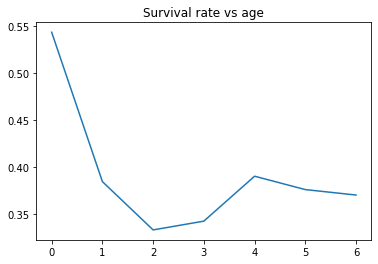

In [28]:
plt.plot(titanic_df.groupby('age')['survived'].mean())
plt.title('Survival rate vs age')
plt.show()

Children are much more likely to survive than other age groups. We can also create a table to examine the interaction of sex and age on survival.

In [29]:
titanic_df.groupby('age')['survived'].value_counts()

age  survived
0    1            44
     0            37
1    0            72
     1            45
2    0            88
     1            44
3    0            94
     1            49
4    0           139
     1            89
5    0            68
     1            41
6    0            51
     1            30
Name: survived, dtype: int64

In [30]:
titanic_df.pivot_table('survived', index='sex', columns='age')

age,0,1,2,3,4,5,6
sex,,,,,,,
0,0.478261,0.114286,0.107143,0.223301,0.182432,0.185714,0.125
1,0.628571,0.787234,0.729167,0.650000,0.775000,0.717949,0.920


In order to avoid overfitting the subsequent models, the age variable itself will be used as a feature, without additional interactions.

__Fare:__

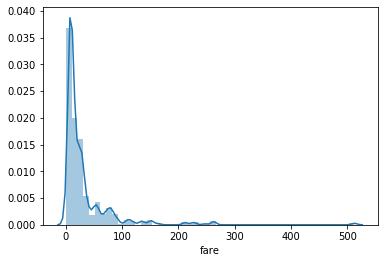

In [31]:
sns.distplot(titanic_df.fare)

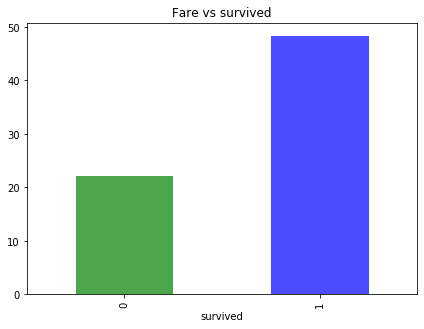

survived
0    22.117887
1    48.395408
Name: fare, dtype: float64

In [32]:
plt.figure(figsize=(7,5))

fare_plot = titanic_df.groupby('survived')['fare'].mean()
fare_plot.plot(kind='bar', color=('green', 'blue'), alpha=.7)
plt.title("Fare vs survived")

plt.show()

fare_plot

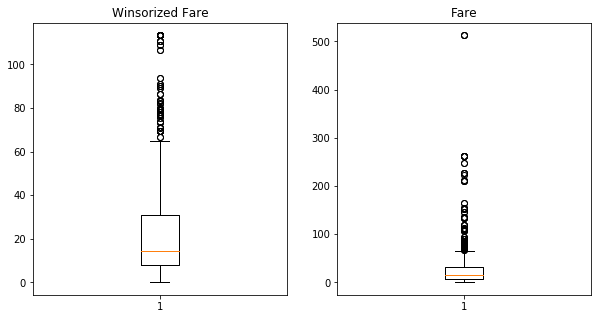

In [33]:
from scipy.stats.mstats import winsorize

for dataset in datasets:
    dataset['winsorized_fare'] = winsorize(dataset['fare'], (0, .05))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot(titanic_df.winsorized_fare)
plt.title('Winsorized Fare')

plt.subplot(1,2,2)
plt.boxplot(titanic_df.fare)
plt.title('Fare')

plt.show()

In [34]:
titanic_df.winsorized_fare.describe()

count    891.000000
mean      27.780882
std       29.400264
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      113.275000
Name: winsorized_fare, dtype: float64

In [35]:
titanic_df.fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: fare, dtype: float64

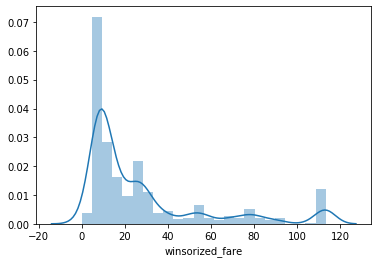

In [36]:
sns.distplot(titanic_df.winsorized_fare)

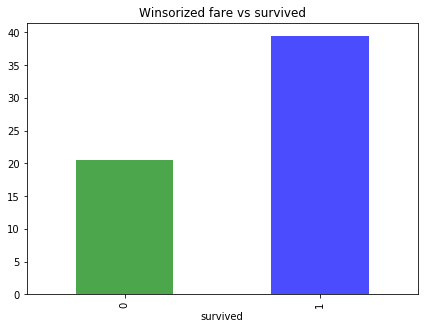

survived
0    20.489889
1    39.484845
Name: winsorized_fare, dtype: float64

In [37]:
plt.figure(figsize=(7,5))

winsorized_fare_plot = titanic_df.groupby('survived')['winsorized_fare'].mean()
winsorized_fare_plot.plot(kind='bar', color=('green', 'blue'), alpha=.7)
plt.title("Winsorized fare vs survived")

plt.show()

winsorized_fare_plot

Winsorized fare will be selected as a feature variable.

__Pclass/Sibsp:__

In [38]:
#Create a new feature that combines parch and sibsp
for dataset in datasets:
    dataset['family_size'] = dataset.sibsp + dataset.parch

Text(0.5, 1, 'Family Size vs Survival Rate')

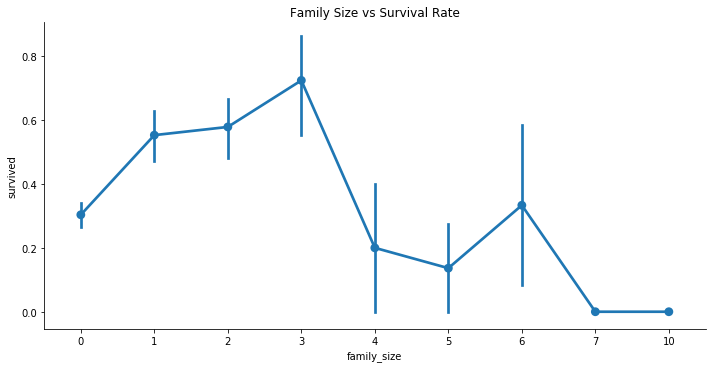

In [39]:
sns.catplot('family_size',
            'survived', 
            data=titanic_df,
            aspect = 2, 
            kind='point')
plt.title('Family Size vs Survival Rate')

Family size appears to have an impact, as smaller families have a higher survival rate than larger ones. Family_size will be used as another feature.

Let's have a final review of correlation to ensure none are too high.

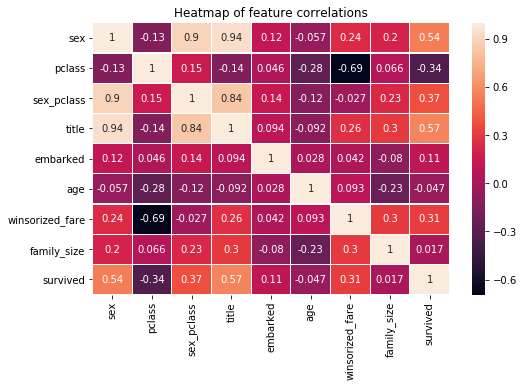

In [40]:
features = titanic_df[[
    'sex',
    'pclass',
    'sex_pclass',
    'title',
    'embarked',
    'age',
    'winsorized_fare',
    'family_size',
    'survived'
]]

plt.figure(figsize=(8,5))
corr = features.corr()
sns.heatmap(corr, annot=True, linewidths=.2)
plt.title('Heatmap of feature correlations')
plt.show()

The interaction of sex and pclass has a very high correlation with sex. Therefore, the interaction is dropped from consideration.

_Note: this decision had little to no consequences in model performance, but did change the importance of the features._

### Building Models

It's time to build different classifier models, based on the set of features described in the last section.

In [41]:
titanic_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,sex_pclass,title,winsorized_fare,family_size
0,1,0,3,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,7.2500,0,0,1,7.2500,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,4,1,0,PC 17599,71.2833,1,1,5,71.2833,1
2,3,1,3,"Heikkinen, Miss. Laina",1,3,0,0,STON/O2. 3101282,7.9250,0,3,4,7.9250,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,4,1,0,113803,53.1000,0,1,5,53.1000,1
4,5,0,3,"Allen, Mr. William Henry",0,4,0,0,373450,8.0500,0,0,1,8.0500,0


In [42]:
#Select features
feature_list = list([
    'sex',
    'pclass',
    #'sex_pclass',
    'title',
    'embarked',
    'age',
    'winsorized_fare',
    'family_size'])

X_train = titanic_df[feature_list]
Y_train = titanic_df.survived

X_test  = titanic_test[feature_list]
Y_test = titanic_test_survival.drop('PassengerId', axis=1)

In [43]:
#Decision Tree
decision_tree = tree.DecisionTreeRegressor()

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=5)
    
decision_tree.fit(X_train, Y_train)

#Training set scores
decision_tree_score = decision_tree.score(X_train, Y_train)  
decision_tree_cvs = cross_val_score(decision_tree, X_train, Y_train, cv=10)

#Test set scores
test_decision_tree_score = decision_tree.score(X_test, Y_test)  
#test_decision_tree_cvs = cross_val_score(decision_tree, X_test, Y_test, cv=10)

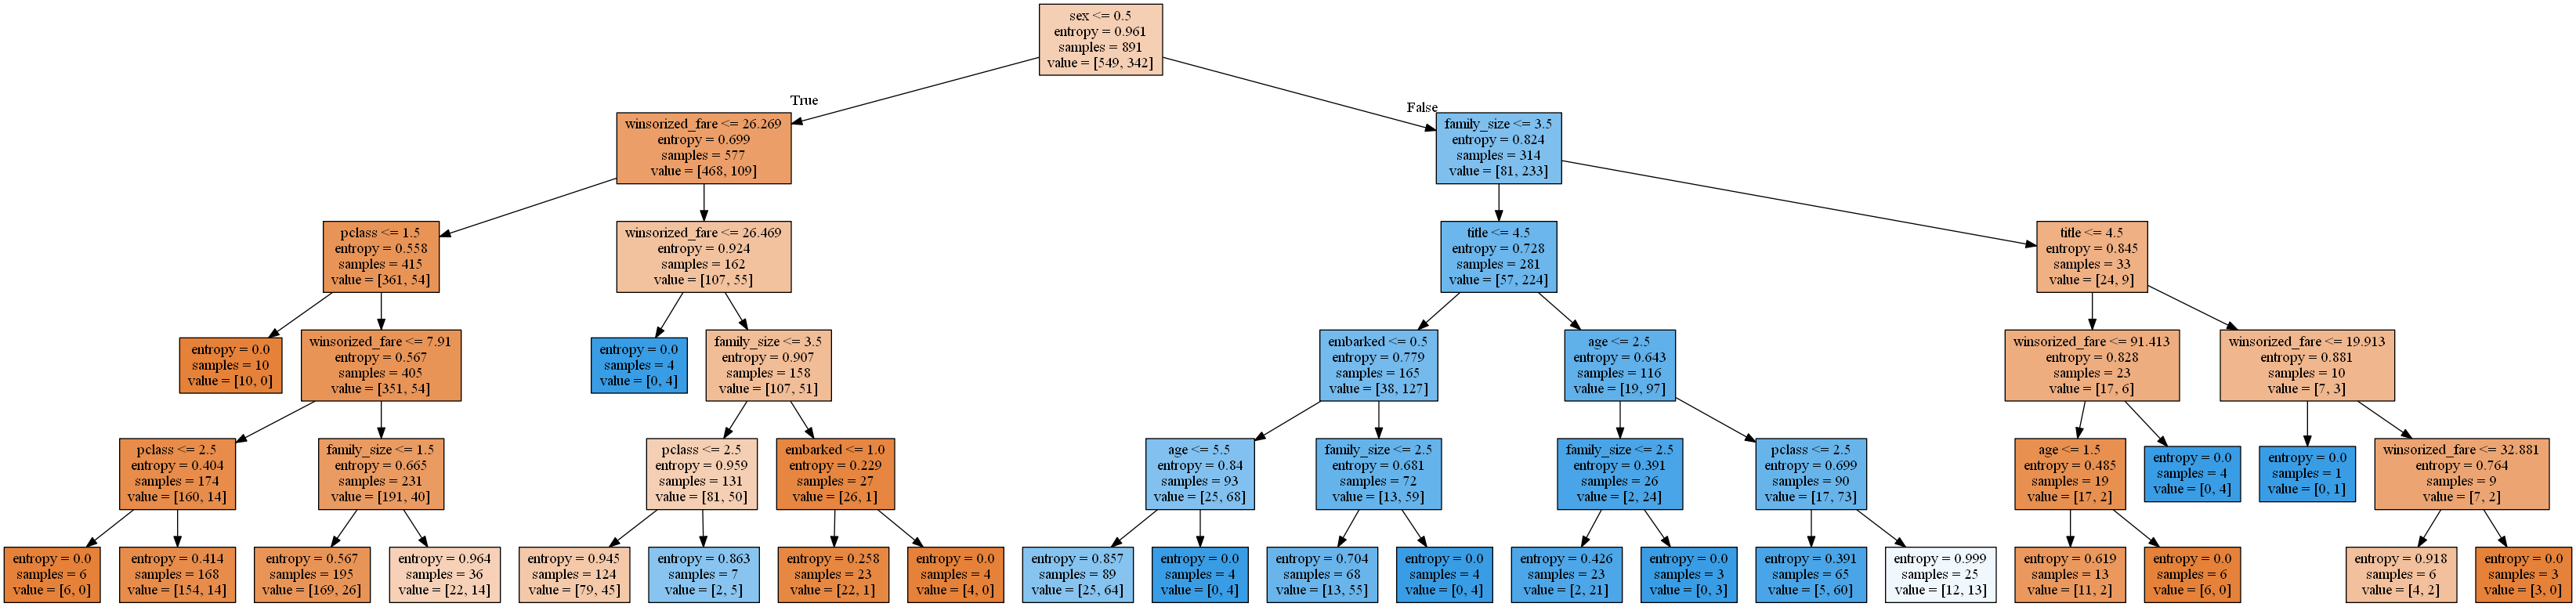

In [44]:
#Render our tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=feature_list,
    #class_names=['Not Returning', 'Returning'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [45]:
#Random Forest Model

from sklearn import ensemble
random_forest = ensemble.RandomForestClassifier(n_estimators=100, 
                                                criterion='entropy',
                                               max_features=1,
                                               max_depth=5)
random_forest.fit(X_train, Y_train)

#Training set scores
rfc_score = random_forest.score(X_train, Y_train)
rfc_cvs = cross_val_score(random_forest, X_train, Y_train, cv=10)

#Test set scores
test_rfc_score = random_forest.score(X_test, Y_test)
#test_rfc_cvs = cross_val_score(random_forest, X_test, Y_test, cv=10)

In [46]:
#SVC

from sklearn.svm import SVC, LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

linear_svc.fit(X_train, Y_train)

#Training set scores
svc_score = linear_svc.score(X_train, Y_train)  
svc_cvs = cross_val_score(linear_svc, X_train, Y_train, cv=10)

#Test set scores
test_svc_score = linear_svc.score(X_test, Y_test)  
#test_svc_cvs = cross_val_score(linear_svc, X_test, Y_test, cv=10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

In [47]:
#KNN

from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

#Training set scores
knn_score = knn.score(X_train, Y_train)
knn_cvs = cross_val_score(knn, X_train, Y_train, cv=10)

#Test set scores
test_knn_score = knn.score(X_test, Y_test)
#test_knn_cvs = cross_val_score(knn, X_test, Y_test, cv=10)

In [48]:
#Gradient Boosting Classifier

params = {'n_estimators': 500,
         # 'max_depth': 2,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, Y_train)

#Training set scores
clf_score = knn.score(X_train, Y_train)
clf_cvs = cross_val_score(knn, X_train, Y_train, cv=10)

#Test set scores
test_clf_score = knn.score(X_test, Y_test)
#test_clf_cvs = cross_val_score(knn, X_test, Y_test, cv=10)

After building all our models, let's visualize the results in a chart for clarity.

In [49]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 
              'Random Forest',
              'Support Vector Machines', 
              'KNN Classifier',
              'Gradient Boosting Classifier'
             ],
    
    'Score (training set)': [decision_tree_score, 
              rfc_score, 
              svc_score, 
              knn_score, 
              clf_score
              ],
    
    'Cross validation score (training set)': [decision_tree_cvs.mean(), 
              rfc_cvs.mean(), 
              svc_cvs.mean(), 
              knn_cvs.mean(), 
              clf_cvs.mean() 
              ],
    
    'Score (test set)': [test_decision_tree_score, 
              test_rfc_score, 
              test_svc_score, 
              test_knn_score, 
              test_clf_score
              ]
    
    })

result_df = results.sort_values(by='Cross validation score (training set)', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score (training set),Cross validation score (training set),Score (test set)
Model,,,
Random Forest,0.843996,0.829385,0.940191
Support Vector Machines,0.821549,0.800283,0.935407
KNN Classifier,0.865320,0.795914,0.849282
Gradient Boosting Classifier,0.865320,0.795914,0.849282
Decision Tree,0.817059,0.793567,0.980861


The Random Forest model appears to be the best choice, as the model consistently has the highest cross validation scores (no overfitting), and has the best performance for the test set.

Now that we have picked a model, let's evaluate the importance of each feature in that random forest model.

In [50]:
#Classification report for Random Forest

from sklearn.metrics import classification_report

#ytrue, ypred
cr = classification_report(Y_train, random_forest.predict(X_train))
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.84      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



In [51]:
#Importance of features
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
title,0.308
sex,0.240
winsorized_fare,0.158
pclass,0.132
family_size,0.088
age,0.047
embarked,0.027


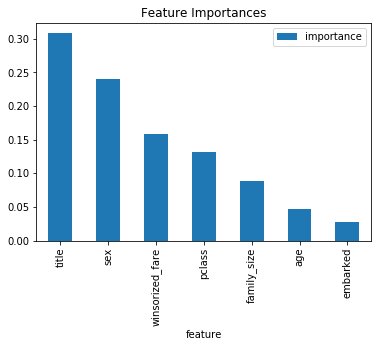

In [52]:
importances.plot.bar()
plt.title("Feature Importances")
plt.show()

Title, sex, and fare are the most important features in this model.

### Tuning parameters

Now that the Random Forest Classifier has been selected, we can try out different parameters to improve the model. Creating a function will be useful.

In [53]:
def adjust_parameters(X, Y, n_estimators, criterion, max_features, max_depth):
    parameters = {
        'n_estimators': n_estimators,
        'criterion': criterion,
        'max_features': max_features,
        'max_depth': max_depth
    }
    random_forest = ensemble.RandomForestClassifier(**parameters)
    random_forest.fit(X, Y)
    rfc_score = random_forest.score(X, Y)
    print('Score:', rfc_score)
    rfc_cvs = cross_val_score(random_forest, X, Y, cv=10)
    print('Cross validation score', rfc_cvs.mean())

In [54]:
from datetime import datetime
start_time = datetime.now()

#Original
adjust_parameters(X_train, Y_train, 100, 'entropy', 1, 5)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Score: 0.8473625140291807
Cross validation score 0.8316189989785496
Duration: 0:00:00.933526


In [55]:
from datetime import datetime
start_time = datetime.now()

#Increase n_estimators
adjust_parameters(X_train, Y_train, 300, 'entropy', 1, 5)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Score: 0.8507295173961841
Cross validation score 0.8293967767563274
Duration: 0:00:02.527269


In [56]:
#Criterion
adjust_parameters(X_train, Y_train, 300, 'gini', 1, 5)

Score: 0.8496071829405163
Cross validation score 0.8316439677675633


In [57]:
#max_features
adjust_parameters(X_train, Y_train, 300, 'gini', None, 5)

Score: 0.867564534231201
Cross validation score 0.834988934286687


In [58]:
#max_depth
adjust_parameters(X_train, Y_train, 300, 'gini', None, None)

Score: 0.957351290684624
Cross validation score 0.8125930654863239


In [59]:
#max_depth
adjust_parameters(X_train, Y_train, 300, 'gini', None, 4)

Score: 0.8451178451178452
Cross validation score 0.8339039269095447


In [60]:
#max_depth
adjust_parameters(X_train, Y_train, 300, 'gini', None, 6)

Score: 0.8855218855218855
Cross validation score 0.8439907501986154


In [61]:
#max_depth
adjust_parameters(X_train, Y_train, 300, 'gini', None, 7)

Score: 0.9023569023569024
Cross validation score 0.8383852570650323


In [62]:
#max_depth
adjust_parameters(X_train, Y_train, 300, 'gini', None, 8)

Score: 0.9191919191919192
Cross validation score 0.8372741459539211


Increasing the number of estimators resulted in a small increase in accuracy of the model, however, it came with an increase in runtime. For this size of data, the increase in runtime was acceptable. Changing the criterion from 'entropy' to 'gini' (default) also appears to have marginally improved the accuracy of the model. Lastly, a max_depth of 7 appears optimal for this data. Aside from those adjustments, using the default paramaters seems appropriate.

The final parameters are: 

    n_estimators = 300, 
    criterion = 'gini',
    max_depth = 7

In [63]:
#Final model

random_forest = ensemble.RandomForestClassifier(
    n_estimators = 300, 
    criterion = 'gini',
    max_depth = 7)

random_forest.fit(X_train, Y_train)
rfc_score = random_forest.score(X_train, Y_train)
print('Score:', rfc_score)
rfc_cvs = cross_val_score(random_forest, X_train, Y_train, cv=10)
print('Cross validation score', rfc_cvs.mean())

Score: 0.8832772166105499
Cross validation score 0.83274202701169


### Making predicitons

The Random Forest model can now be used to predict the survival of passengers in the test data set.

In [64]:
Y_pred = random_forest.predict(X_test)
predictions = pd.DataFrame({
        "PassengerId": titanic_test["passengerid"],
        "Survived": Y_pred
    })

In [65]:
predictions.to_csv('predictions.csv', index=False)
print("Predictions saved!")

Predictions saved!


In [66]:
#Predictions for fun
#'sex','pclass','title','embarked','age','fare','family_size'
#Assuming I'm traveling with my dad and brother, second class
Jacob_survival = [[0, 2, 1, 1, 26, 20, 2]]
Jacob_pred = random_forest.predict_proba(Jacob_survival)
print(Jacob_pred)

[[0.89423622 0.10576378]]


There is a 84% chance I would not survive the Titanic, based on my inputs!

In [67]:
#Titanic characters

#Jack= male, third class, mr, Southhampton England, 20, cheap, alone
Jack_Dawson_survival = [[0, 3, 1, 0, 20, 10, 0]]
Jack_Dawson_pred = random_forest.predict_proba(Jack_Dawson_survival)
print('Jack Dawson:', Jack_Dawson_pred)

#Rose= female, first class, miss, Southhampton, 17, expensive, parents plus fiance(3)
Rose_DeWitt_Bukater_survival = [[1, 1, 2, 0, 17, 150, 3]]
Rose_DeWitt_Bukater_pred = random_forest.predict_proba(Rose_DeWitt_Bukater_survival)
print('Rose DeWitt Bukater:', Rose_DeWitt_Bukater_pred)

Jack Dawson: [[0.89272629 0.10727371]]
Rose DeWitt Bukater: [[0.17807568 0.82192432]]


Jack's chance of survival is only 9.5%, while Rose has a 78% chance of survival!